Import libraries used for this demo
----------------


In [19]:
import sys
sys.path.insert(0, '../../')
import fwdnxt
import sys
import PIL
from PIL import Image
import numpy as np

Download the resnet18 ONNX model
----------------

You can use any other torchvision model in ONNX format

In [20]:
import urllib.request
urllib.request.urlretrieve("http://fwdnxt.com/models/resnet18.onnx", filename="resnet18.onnx")

('resnet18.onnx', <http.client.HTTPMessage at 0x7fb8bd5e2668>)

Parameters of this demo
----------------

In [21]:
w = h = 224 #width and height of the image
p = 3 #image planes
bitfile = ''  #path to a bitfile to load the FPGA
#bitfile = <path to the bitfile>
outfile = 'save.bin' #save the compilation as .bin file

modelfile = 'resnet18.onnx' # <<< change the path of the model !

categories = '../../test-files/categories.txt' #list of categories for ImageNet

Loading the input image
----------------
The following cells will load the input image and pre-process it

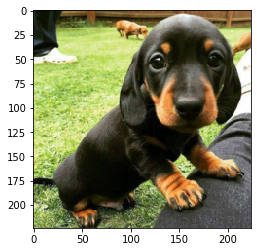

In [23]:
#Load image into a numpy array
img = Image.open('../../test-files/dog.jpg')
#Resize it to the size expected by the network
img = img.resize((w, h), resample=PIL.Image.BILINEAR)

import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [24]:
#Convert to numpy float
img = np.array(img).astype(np.float32) / 255
#Transpose to plane-major, as required by our API
img = np.ascontiguousarray(img.transpose(2,0,1))
#Normalize images
stat_mean = list([0.485, 0.456, 0.406])
stat_std = list([0.229, 0.224, 0.225])
for i in range(3):
    img[i] = (img[i] - stat_mean[i])/stat_std[i]

Compiler, Init and Run 
----------------
This are the only lines of code needed to run the model on the accelerator

In [25]:
#Create and initialize the Inference Engine object
ie = fwdnxt.FWDNXT()
#Compile to a file
swnresults = ie.Compile("{:d}x{:d}x{:d}".format(w, h, p), modelfile, outfile)
#Init fpga
nresults = ie.Init(outfile, bitfile)
#Create the storage for the result and run one inference
result = np.ndarray(swnresults, dtype=np.float32)
ie.Run(img, result)

Recover the output
----------------
The output of the model is converted into text. Top-5 classification are printed

In [26]:
#Convert to numpy and print top-5
idxs = (-result).argsort()

print('')
print('-------------- Results --------------')
if categories != '':
    with open(categories) as f:
        categories = f.read().splitlines()
        for i in range(5):
            print(categories[idxs[i]], result[idxs[i]])
else:
    for i in range(5):
        print(idxs[i], result[idxs[i]])

#Free
ie.Free()
print('done')


-------------- Results --------------
Rottweiler 13.753906
black-and-tan coonhound 13.2734375
Doberman 12.488281
Gordon setter 11.2890625
bloodhound 11.035156
done
